# ==============================>
# 1. Imports and Configs
# ==============================>

In [1]:
import json
import os

import kagglehub as kh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats

C:\Cryp2Real\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ==============================>
# 2. Download and Database Read
# ==============================>

In [2]:
path = kh.dataset_download("fronkongames/steam-games-dataset")
json_path = os.path.join(path, 'games.json')

with open(json_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# ==============================>
# 3. DataFrame Conversion
# ==============================>

In [3]:
games_list = []
for app_id, game in dataset.items():

    price = game.get('price', 0)
    try:
        # alguns preços vêm como 'Free' ou strings tipo '0.0'
        price = float(price) if price not in ["Free", ""] else 0.0
    except (ValueError, TypeError):
        price = 0.0

    # === Trata MetacriticScore (converte string para número ou NaN) ===
    meta = game.get('metacritic_score')
    try:
        meta = float(meta)
    except (ValueError, TypeError):
        meta = np.nan

    # === Monta o dicionário principal ===
    game_data = {
        'AppID': app_id,
        'Name': game.get('name', ''),
        'RequiredAge': int(game.get('required_age', 0) or 0),
        'ReleaseDate': game.get('release_date', ''),
        'Price': price,
        'MetacriticScore': meta,
        'DlcCount': int(game.get('dlc_count', 0) or 0),
        'DetailedDescription': game.get('detailed_description', ''),
        'AboutTheGame': game.get('about_the_game', ''),
        'Reviews': game.get('reviews', ''),
        'HeaderImage': game.get('header_image', ''),
        'Website': game.get('website', ''),
        'Achievements': int(game.get('achievements', 0) or 0),
        'Recommendations': int(game.get('recommendations', 0) or 0),
        'Notes': game.get('notes', ''),
        'SupportedLanguages': game.get('supported_languages', ''),
        'Developers': game.get('developers', ''),
        'Publishers': game.get('publishers', ''),
        'EstimatedOwners': game.get('estimated_owners', ''),
        'Positive': int(game.get('positive', 0) or 0),
        'Negative': int(game.get('negative', 0) or 0),
        'PeakCCU': int(game.get('peak_ccu', 0) or 0),
        'AveragePlaytimeForever': int(game.get('average_playtime_forever', 0) or 0),
        'AveragePlaytime2Weeks': int(game.get('average_playtime_2weeks', 0) or 0),
        'MedianPlaytimeForever': int(game.get('median_playtime_forever', 0) or 0),
        'MedianPlaytime2Weeks': int(game.get('median_playtime_2weeks', 0) or 0),
        'Genres': ', '.join(game.get('genres', [])) if isinstance(game.get('genres'), list) else '',
        'Categories': ', '.join(game.get('categories', [])) if isinstance(game.get('categories'), list) else '',
        'Screenshots': len(game.get('screenshots', [])) if isinstance(game.get('screenshots'), list) else 0,
        'Movies': len(game.get('movies', [])) if isinstance(game.get('movies'), list) else 0
    }

    games_list.append(game_data)

df = pd.DataFrame(games_list)
print(f"📊 DataFrame: {df.shape[0]} lines and {df.shape[1]} columns")

📊 DataFrame: 111452 lines and 30 columns


# ==============================>
# 4. Save CSV
# ==============================>

In [4]:
df.to_csv("steam_games.csv", encoding="utf-8", index=False)

# ==============================>

# 5. Questions

# ==============================>

# Question 1 : What kind of correlation exists between Price and MetaScore?

In [5]:
# ==================================================================================================
# Question 1: What kind of correlation exists between Price and MetaScore?
# ==================================================================================================

# Columns to show in the interactive plot
cols_to_keep = ['Price', 'MetacriticScore', 'Name', 'Developers', 'Publishers']

# Remove null values from Price and MetacriticScore
df_corr = df[cols_to_keep].dropna(subset=['Price', 'MetacriticScore'])
df_corr = df_corr[(df_corr['Price'] > 0) & (df_corr['MetacriticScore'] > 0)]

# ============================================
# Statistical Analysis (Correlation)
# ============================================

# Pearson Correlation (Linear)
pearson_corr, pearson_pval = stats.pearsonr(df_corr['Price'], df_corr['MetacriticScore'])

print(f"1. PEARSON CORRELATION (Price vs Metacritic Score):")

print("\n" + "="*60)
print("QUICK INTERPRETATION")
print("="*60)
print(f"Pearson's r ({pearson_corr:.3f}) indicates a very weak linear correlation.")
print(f"Price explains only {(pearson_corr**2)*100:.2f}% of the variation in Metacritic scores.")
print("="*60)


# ============================================
# Visualization 1: Price vs Metacritic Rating (Colored by Price Range)
# ============================================

# Create price range categories
def categorize_price(price):
    if price < 10:
        return '$0-10 (Budget)'
    elif price < 20:
        return '$10-20 (Low)'
    elif price < 40:
        return '$20-40 (Mid)'
    elif price < 60:
        return '$40-60 (Premium)'
    else:
        return '$60+ (AAA)'

# Add price category column
df_corr['PriceCategory'] = df_corr['Price'].apply(categorize_price)

# Define color mapping for each price range
color_map = {
    '$0-10 (Budget)': '#00ff00',      # Green
    '$10-20 (Low)': '#ffff00',        # Yellow
    '$20-40 (Mid)': '#ff0000',        # Red
    '$40-60 (Premium)': '#ff8c00',    # Orange
    '$60+ (AAA)': '#8b00ff'           # Purple
}

# Create scatter plot with colors by price range
fig1 = px.scatter(
    df_corr,
    x='Price',
    y='MetacriticScore',
    title='Price vs. Metacritic Rating (Colored by Price Range)',
    color='PriceCategory',
    color_discrete_map=color_map,
    hover_data={
        'Name': True,
        'Developers': True,
        'Publishers': True,
        'Price': ':.2f',
        'MetacriticScore': True,
        'PriceCategory': False
    },
    category_orders={
        'PriceCategory': [
            '$0-10 (Budget)',
            '$10-20 (Low)',
            '$20-40 (Mid)',
            '$40-60 (Premium)',
            '$60+ (AAA)'
        ]
    }
)

# Update layout for better appearance
fig1.update_layout(
    xaxis_title="Price (USD)",
    yaxis_title="Metacritic Score",
    legend_title="Price Range",
    font=dict(size=12),
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    showlegend=True
)

# Update marker size and opacity
fig1.update_traces(
    marker=dict(
        size=8,
        opacity=0.7,
        line=dict(width=0.5, color='white')
    )
)

fig1.show()

# Print statistics by price range
print("\n" + "="*60)
print("STATISTICS BY PRICE RANGE")
print("="*60)
for category in ['$0-10 (Budget)', '$10-20 (Low)', '$20-40 (Mid)', '$40-60 (Premium)', '$60+ (AAA)']:
    subset = df_corr[df_corr['PriceCategory'] == category]
    if len(subset) > 0:
        print(f"\n{category}:")
        print(f"  Games: {len(subset)}")
        print(f"  Avg Metacritic: {subset['MetacriticScore'].mean():.2f}")
        print(f"  Avg Price: ${subset['Price'].mean():.2f}")


# ============================================
# Visualization 2: Price vs Metacritic Rating (Colored by Review Quality)
# ============================================

# Create score quality categories
def categorize_score(score):
    if score >= 80:
        return 'Excellent (80-100)'
    elif score >= 60:
        return 'Good (60-79)'
    elif score >= 40:
        return 'Mixed (40-59)'
    elif score >= 20:
        return 'Poor (20-39)'
    else:
        return 'Bad (0-19)'

# Add score category column
df_corr['ScoreCategory'] = df_corr['MetacriticScore'].apply(categorize_score)

# Define color mapping for each score range
score_color_map = {
    'Excellent (80-100)': '#00ff00',  # Green - Excellent games
    'Good (60-79)': '#9acd32',        # Yellow-Green - Good games
    'Mixed (40-59)': '#ffa500',       # Orange - Mixed reviews
    'Poor (20-39)': '#ff4500',        # Orange-Red - Poor games
    'Bad (0-19)': '#ff0000'           # Red - Bad games
}

# Create scatter plot with colors by score quality
fig2 = px.scatter(
    df_corr,
    x='Price',
    y='MetacriticScore',
    title='Price vs. Metacritic Rating (Colored by Review Quality)',
    color='ScoreCategory',
    color_discrete_map=score_color_map,
    hover_data={
        'Name': True,
        'Developers': True,
        'Publishers': True,
        'Price': ':.2f',
        'MetacriticScore': True,
        'ScoreCategory': False
    },
    category_orders={
        'ScoreCategory': [
            'Excellent (80-100)',
            'Good (60-79)',
            'Mixed (40-59)',
            'Poor (20-39)',
            'Bad (0-19)'
        ]
    }
)

# Update layout for better appearance
fig2.update_layout(
    xaxis_title="Price (USD)",
    yaxis_title="Metacritic Score",
    legend_title="Review Quality",
    font=dict(size=12),
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    showlegend=True
)

# Update marker size and opacity
fig2.update_traces(
    marker=dict(
        size=8,
        opacity=0.7,
        line=dict(width=0.5, color='white')
    )
)

fig2.show()

# Print statistics by score quality
print("\n" + "="*60)
print("STATISTICS BY REVIEW QUALITY")
print("="*60)
for category in ['Excellent (80-100)', 'Good (60-79)', 'Mixed (40-59)', 'Poor (20-39)', 'Bad (0-19)']:
    subset = df_corr[df_corr['ScoreCategory'] == category]
    if len(subset) > 0:
        print(f"\n{category}:")
        print(f"  Games: {len(subset)}")
        print(f"  Avg Price: ${subset['Price'].mean():.2f}")
        print(f"  Avg Metacritic: {subset['MetacriticScore'].mean():.2f}")

# End of Question 1
# ==================================================================================================


1. PEARSON CORRELATION (Price vs Metacritic Score):

QUICK INTERPRETATION
Pearson's r (0.235) indicates a very weak linear correlation.
Price explains only 5.51% of the variation in Metacritic scores.



STATISTICS BY PRICE RANGE

$0-10 (Budget):
  Games: 1552
  Avg Metacritic: 70.79
  Avg Price: $7.30

$10-20 (Low):
  Games: 1446
  Avg Metacritic: 73.73
  Avg Price: $17.23

$20-40 (Mid):
  Games: 561
  Avg Metacritic: 75.90
  Avg Price: $30.47

$40-60 (Premium):
  Games: 129
  Avg Metacritic: 79.81
  Avg Price: $55.77

$60+ (AAA):
  Games: 7
  Avg Metacritic: 83.71
  Avg Price: $69.99



STATISTICS BY REVIEW QUALITY

Excellent (80-100):
  Games: 1093
  Avg Price: $19.94
  Avg Metacritic: 83.93

Good (60-79):
  Games: 2210
  Avg Price: $15.59
  Avg Metacritic: 71.46

Mixed (40-59):
  Games: 365
  Avg Price: $12.14
  Avg Metacritic: 53.08

Poor (20-39):
  Games: 27
  Avg Price: $11.90
  Avg Metacritic: 33.89


# Question 5 : How does time since release affect number of recommendations / reviews?

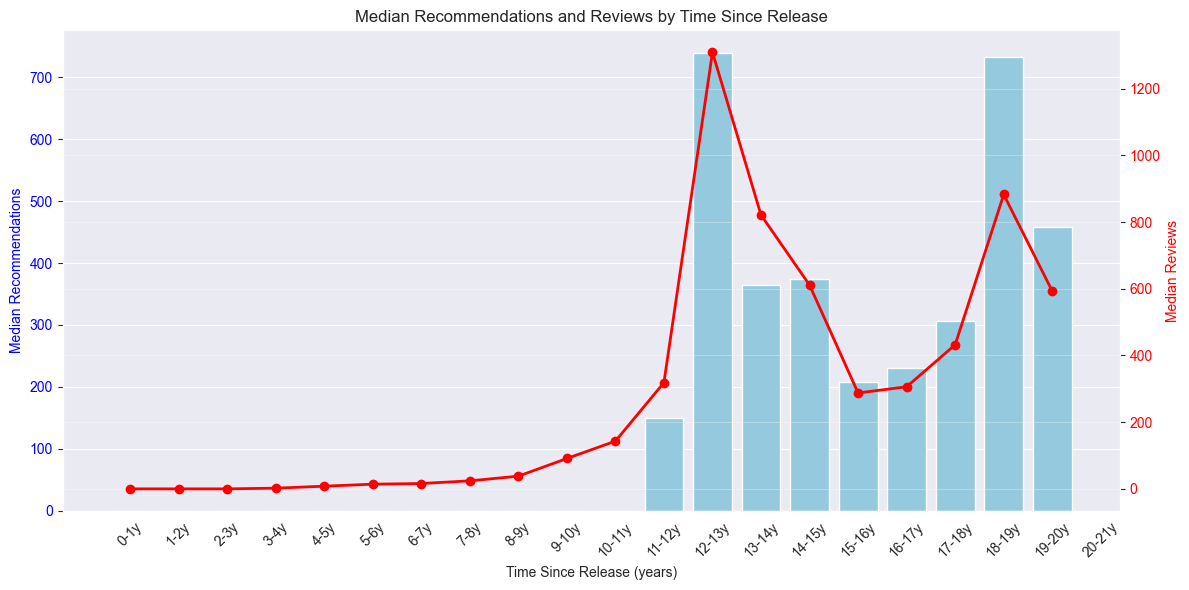


Observation:
- Older games accumulate more recommendations and reviews.
- Very recent games have low numbers, independent of quality.
- Using medians per release-year bin smooths the extreme disparities and shows trend clearly.



In [6]:
# Ensure TotalReviews exists
df['TotalReviews'] = df['Positive'] + df['Negative']

# Convert ReleaseDate to datetime
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')

# Calculate days since release
df['DaysSinceRelease'] = (pd.Timestamp('today') - df['ReleaseDate']).dt.days

# Drop rows with missing values
df_time = df[['DaysSinceRelease', 'Recommendations', 'TotalReviews']].dropna()

# Create bins for days since release (intervals de 1 ano = 365 dias)
max_days = int(df_time['DaysSinceRelease'].max())
bins = list(range(0, max_days + 365, 365))

labels = [f"{i}-{i+1}y" for i in range(len(bins)-1)]
df_time['ReleaseBin'] = pd.cut(df_time['DaysSinceRelease'], bins=bins, labels=labels, right=False)

# Aggregate medians by bin
time_stats = df_time.groupby('ReleaseBin', observed = False).agg( # observed = False to avoid deprecated 'error'
    MedianRecommendations=('Recommendations', 'median'),
    MedianReviews=('TotalReviews', 'median'),
    Count=('DaysSinceRelease', 'count')
).reset_index()

# Only keep bins with enough games
time_stats = time_stats[time_stats['Count'] >= 20]

# ==============================
# Visualization: Median Recommendations and Reviews by Time Since Release
# ==============================

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for Median Recommendations
sns.barplot(x='ReleaseBin', y='MedianRecommendations', data=time_stats, color='skyblue', ax=ax1)
ax1.set_xlabel('Time Since Release (years)')
ax1.set_ylabel('Median Recommendations', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Line plot for Median Reviews
ax2 = ax1.twinx()
ax2.plot(time_stats['ReleaseBin'], time_stats['MedianReviews'], color='red', marker='o', linewidth=2, label='Median Reviews')
ax2.set_ylabel('Median Reviews', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Median Recommendations and Reviews by Time Since Release')
plt.grid(True, alpha=0.3)
plt.tight_layout()
#fig.savefig('question5_median_Recommendations_by_Time_Since_Release.png', dpi=300, bbox_inches='tight')
plt.show()


print("""
Observation:
- Older games accumulate more recommendations and reviews.
- Very recent games have low numbers, independent of quality.
- Using medians per release-year bin smooths the extreme disparities and shows trend clearly.
""")

# Question 8: Is it worth investing in DLCs? Do they really increase game lifespan and revenue?


Games WITH DLCs:
  Median Playtime: 255.00
  Avg Price: 12.86
  Avg Estimated Owners: 332,132.56
  Avg Review Ratio: 0.80

Games WITHOUT DLCs:
  Median Playtime: 186.00
  Avg Price: 7.35
  Avg Estimated Owners: 59,404.77
  Avg Review Ratio: 0.76


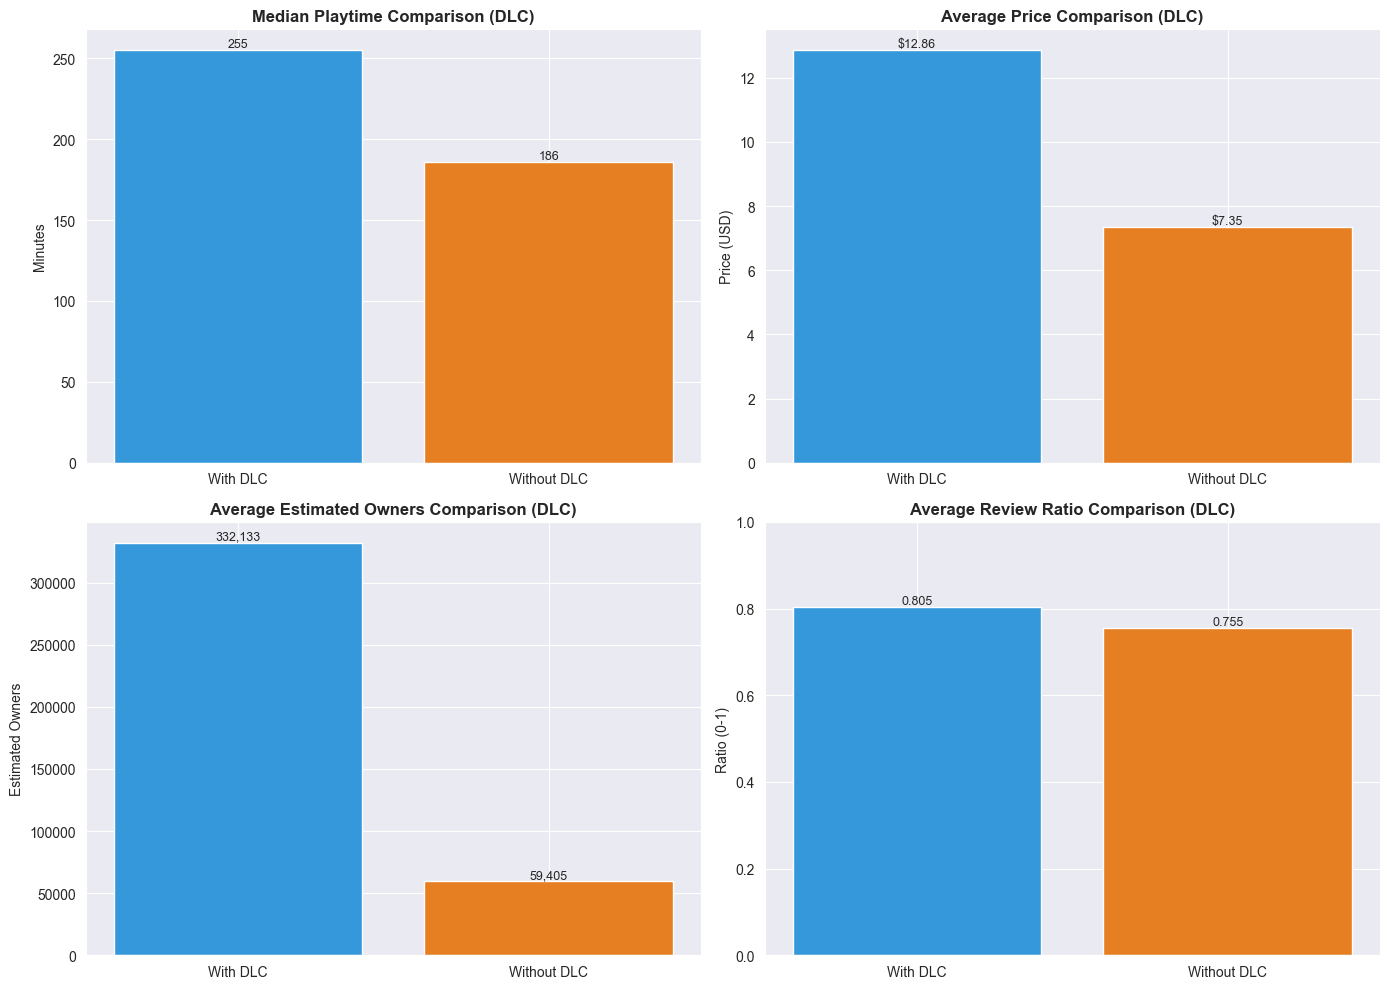

In [7]:
# Convert owners to numeric
def owners_to_number(owners):
    if type(owners) != str or '-' not in owners:
        return np.nan

    parts = owners.replace(',', '').split('-')
    return (int(parts[0]) + int(parts[1])) / 2

# Segment games by DLC presence
with_dlc = df[df['DlcCount'] > 0].copy()
without_dlc = df[df['DlcCount'] == 0].copy()

with_dlc['EstimatedOwnersNumeric'] = with_dlc['EstimatedOwners'].apply(owners_to_number)
without_dlc['EstimatedOwnersNumeric'] = without_dlc['EstimatedOwners'].apply(owners_to_number)

# Calculate Review Ratio
with_dlc['ReviewRatio'] = with_dlc['Positive'] / (with_dlc['Positive'] + with_dlc['Negative'])
without_dlc['ReviewRatio'] = without_dlc['Positive'] / (without_dlc['Positive'] + without_dlc['Negative'])

# Clean data
with_dlc = with_dlc.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio', 'EstimatedOwnersNumeric'])
without_dlc = without_dlc.replace([np.inf, -np.inf], np.nan).dropna(subset=['ReviewRatio', 'EstimatedOwnersNumeric'])

# Filter games with playtime > 0 for meaningful comparison
with_dlc_playtime = with_dlc[with_dlc['MedianPlaytimeForever'] > 0]
without_dlc_playtime = without_dlc[without_dlc['MedianPlaytimeForever'] > 0]

# Calculate metrics
metrics_with_dlc = {
    'Median Playtime': with_dlc_playtime['MedianPlaytimeForever'].median(),
    'Avg Price': with_dlc['Price'].mean(),
    'Avg Estimated Owners': with_dlc['EstimatedOwnersNumeric'].mean(),
    'Avg Review Ratio': with_dlc['ReviewRatio'].mean()
}

metrics_without_dlc = {
    'Median Playtime': without_dlc_playtime['MedianPlaytimeForever'].median(),
    'Avg Price': without_dlc['Price'].mean(),
    'Avg Estimated Owners': without_dlc['EstimatedOwnersNumeric'].mean(),
    'Avg Review Ratio': without_dlc['ReviewRatio'].mean()
}

print("\nGames WITH DLCs:")
for key, value in metrics_with_dlc.items():
    print(f"  {key}: {value:,.2f}")

print("\nGames WITHOUT DLCs:")
for key, value in metrics_without_dlc.items():
    print(f"  {key}: {value:,.2f}")

# ------ Bar Charts ------
categories_dlc = ['With DLC', 'Without DLC']
colors_dlc = ['#3498db', '#e67e22']

plt.figure(figsize=(14, 10))

# 1. Median Playtime
plt.subplot(2, 2, 1)
playtime_values_dlc = [metrics_with_dlc['Median Playtime'], metrics_without_dlc['Median Playtime']]
bars1 = plt.bar(categories_dlc, playtime_values_dlc, color=colors_dlc)
plt.title('Median Playtime Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Minutes', fontsize=10)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 2. Average Price
plt.subplot(2, 2, 2)
price_values = [metrics_with_dlc['Avg Price'], metrics_without_dlc['Avg Price']]
bars2 = plt.bar(categories_dlc, price_values, color=colors_dlc)
plt.title('Average Price Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'${height:,.2f}', ha='center', va='bottom', fontsize=9)

# 3. Average Estimated Owners
plt.subplot(2, 2, 3)
owners_values = [metrics_with_dlc['Avg Estimated Owners'], metrics_without_dlc['Avg Estimated Owners']]
bars3 = plt.bar(categories_dlc, owners_values, color=colors_dlc)
plt.title('Average Estimated Owners Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Estimated Owners', fontsize=10)

for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 4. Average Review Ratio
plt.subplot(2, 2, 4)
ratio_values_dlc = [metrics_with_dlc['Avg Review Ratio'], metrics_without_dlc['Avg Review Ratio']]
bars4 = plt.bar(categories_dlc, ratio_values_dlc, color=colors_dlc)
plt.title('Average Review Ratio Comparison (DLC)', fontsize=12, fontweight='bold')
plt.ylabel('Ratio (0-1)', fontsize=10)
plt.ylim(0, 1)

for bar in bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('question8_dlc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================================================================================================

# Question 9: What price range maximizes the relationship between player satisfaction and sales volume?
# Which price should I put in my indie game?


Metrics by price range:
  PriceRange  ReviewRatio  EstimatedOwnersNumeric  Recommendations
0       $0-5     0.754774            36411.558724       155.271207
1      $5-10     0.782657            66229.855072       571.693449
2     $10-20     0.792496           120869.531311      1673.426733
3     $20-40     0.774367           279288.793103      4218.356609
4       $40+     0.738324           467190.831557      7326.557569


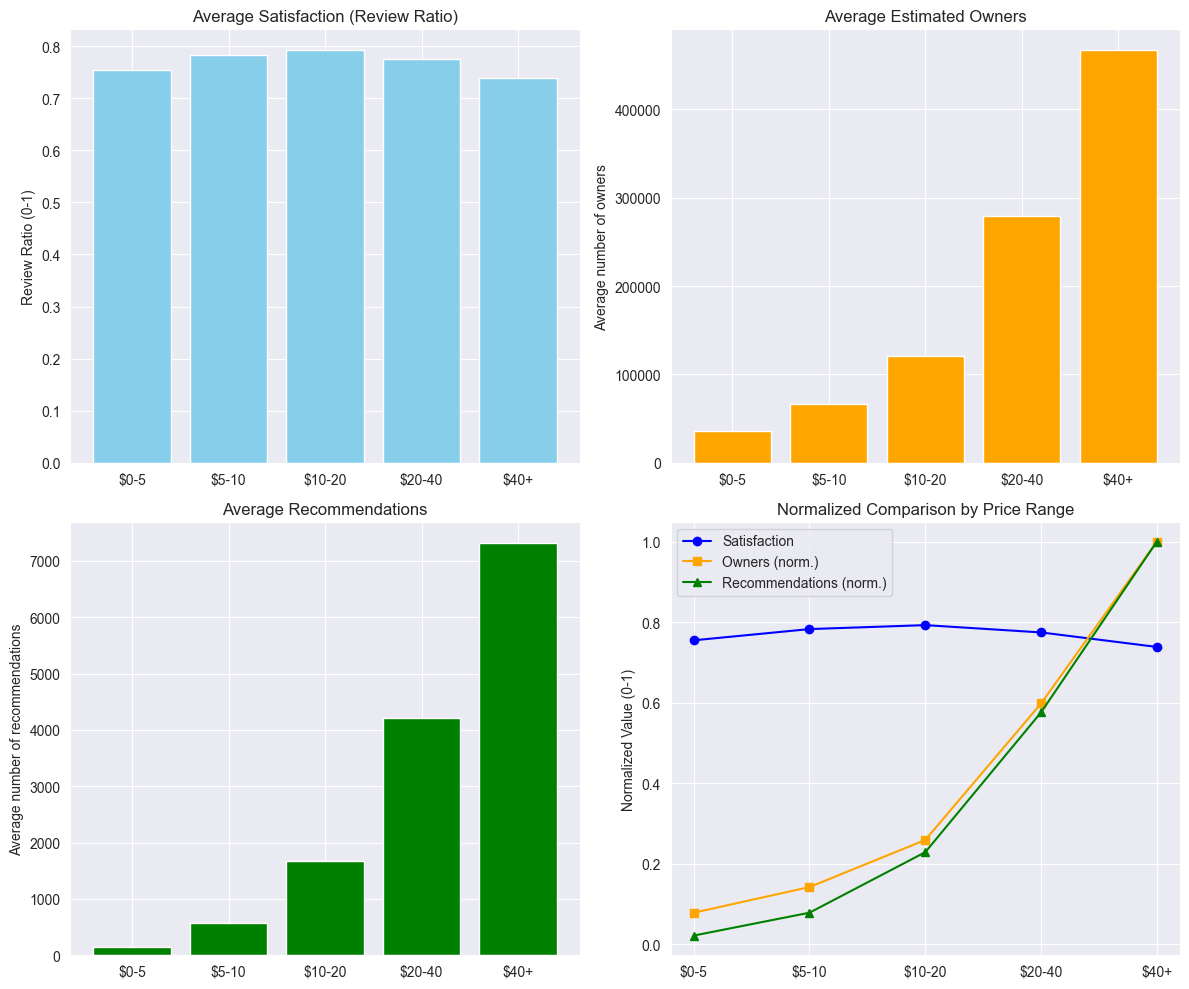


Ideal price range: $40+
  Review Ratio: 0.738
  Average owners: 467,191
  Average recommendations: 7,327


In [8]:
# Convert EstimatedOwners to numeric
df["EstimatedOwnersNumeric"] = df["EstimatedOwners"].apply(owners_to_number)

# Ensure necessary columns exist
df["ReviewRatio"] = df["Positive"] / (df["Positive"] + df["Negative"])
df["ReviewRatio"] = df["ReviewRatio"].replace([np.inf, -np.inf], np.nan)

# Create price ranges
df["PriceRange"] = pd.cut(df["Price"], bins=[0, 5, 10, 20, 40, float("inf")], labels=["$0-5", "$5-10", "$10-20", "$20-40", "$40+"])

# Filter only valid data
valid_data = df.dropna(subset=["ReviewRatio", "EstimatedOwnersNumeric", "Recommendations", "PriceRange"])

# Calculate averages by price range
stats = valid_data.groupby("PriceRange", observed=True).agg({
    "ReviewRatio": "mean",
    "EstimatedOwnersNumeric": "mean",
    "Recommendations": "mean"
}).reset_index()

print("\nMetrics by price range:")
print(stats)

# --- Bar charts (4 subplots) ---
plt.figure(figsize=(12, 10))

# 1. Average Review Ratio
plt.subplot(2, 2, 1)
plt.bar(stats["PriceRange"], stats["ReviewRatio"], color="skyblue")
plt.title("Average Satisfaction (Review Ratio)")
plt.ylabel("Review Ratio (0-1)")

# 2. Average estimated owners
plt.subplot(2, 2, 2)
plt.bar(stats["PriceRange"], stats["EstimatedOwnersNumeric"], color="orange")
plt.title("Average Estimated Owners")
plt.ylabel("Average number of owners")

# 3. Average recommendations
plt.subplot(2, 2, 3)
plt.bar(stats["PriceRange"], stats["Recommendations"], color="green")
plt.title("Average Recommendations")
plt.ylabel("Average number of recommendations")

# 4. Normalized comparison of three metrics
stats_norm = stats.copy()
stats_norm["OwnersNorm"] = stats["EstimatedOwnersNumeric"] / stats["EstimatedOwnersNumeric"].max()
stats_norm["RecsNorm"] = stats["Recommendations"] / stats["Recommendations"].max()

plt.subplot(2, 2, 4)
plt.plot(stats["PriceRange"], stats["ReviewRatio"], marker="o", label="Satisfaction", color="blue")
plt.plot(stats["PriceRange"], stats_norm["OwnersNorm"], marker="s", label="Owners (norm.)", color="orange")
plt.plot(stats["PriceRange"], stats_norm["RecsNorm"], marker="^", label="Recommendations (norm.)", color="green")
plt.title("Normalized Comparison by Price Range")
plt.ylabel("Normalized Value (0-1)")
plt.legend()

plt.tight_layout()
# plt.savefig('question9_') todo
plt.show()

# Determine the ideal range (sweet spot)
stats["BalanceScore"] = (
        stats["ReviewRatio"] * 0.4 +
        (stats["EstimatedOwnersNumeric"] / stats["EstimatedOwnersNumeric"].max()) * 0.3 +
        (stats["Recommendations"] / stats["Recommendations"].max()) * 0.3
)

best_range = stats.loc[stats["BalanceScore"].idxmax()]

print(f"\nIdeal price range: {best_range['PriceRange']}")
print(f"  Review Ratio: {best_range['ReviewRatio']:.3f}")
print(f"  Average owners: {best_range['EstimatedOwnersNumeric']:,.0f}")
print(f"  Average recommendations: {best_range['Recommendations']:,.0f}")

# Question 10: Which supported languages generate greater global reach without compromising ratings?